# SARIMA Cross-validation and GridSearch
Feb 28th 2022

In [1]:
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import os
print(os.getcwd())
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape
import src.colorsetup
import warnings
warnings.filterwarnings('ignore')

/home/razielar/miniconda3/envs/time-series/bin/python
/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series_forecasting/time_series_analysis/week_3/2_arima_sarima_models


In [2]:
def cross_validate(series, horizon, start, step_size, order= (0,0,0), seasonal_order= (0,0,0,0), trend= None):
    '''
    Function to determine in and out of samples for testing of ARIMA model
    ------
    arguments:
        series (series): time series input
        horizon (int): how far in advance forecast is needed
        start (int): starting location in series
        step_size (int): how often to recalculate forecast
        order (tuple): (p,d,q) order of the model
        seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    Return
    ------
    Dataframe: gives forecast and actuals with date of prediction
    '''
    fcst= []
    actual= []
    date= []
    for i in range(start, len(series)- horizon, step_size):
        print(i)
        print(series[i])
        print(series[:i+1])
        model= SARIMAX(series[:i+1], order= order, seasonal_order= seasonal_order, trend= trend).fit()
        fcst.append(model.forecast(steps= horizon)[-1])
        actual.append(series[i+horizon])
        date.append(series.index[i+horizon])
    return pd.DataFrame({'forecast': fcst, 'actual': actual}, index= date)

## Input data

In [3]:
data= "./course_data/"
monthly_temp= pd.read_csv(data+"mean-monthly-temperature-1907-19.csv", 
                          names= ["month", "temp"], skipfooter= 2, engine= 'python',
                          infer_datetime_format= True, header= 0, index_col= 0)
monthly_temp.index= pd.to_datetime(monthly_temp.index)
# 'A'= annually
annual_temp=  monthly_temp.resample('A').mean()
# Differencing by season:
monthly_temp['lag_12']= monthly_temp.shift(12)
# display(monthly_temp.head(14))
monthly_temp['seasonal_diff']= monthly_temp.temp - monthly_temp.lag_12
# display(monthly_temp.head(14))
# Head
print(monthly_temp.shape)
monthly_temp.head(13)

(792, 3)


,temp,lag_12,seasonal_diff
month,,,
1907-01-01,33.3,NaN,NaN
1907-02-01,46.0,NaN,NaN
1907-03-01,43.0,NaN,NaN
1907-04-01,55.0,NaN,NaN
1907-05-01,51.8,NaN,NaN
1907-06-01,57.5,NaN,NaN
1907-07-01,74.8,NaN,NaN
1907-08-01,75.6,NaN,NaN
1907-09-01,66.3,NaN,NaN


In [ ]:
cv1= cross_validate(series= monthly_temp.temp, horizon= 12, start= 700, step_size= 1,
                    order= (1,0,0), seasonal_order= (0,1,1,12))

In [5]:
# Example to see CV:
series= monthly_temp.temp
horizon= 12
start= 700
step_size= 1
order= (1,0,0)
seasonal_order= (0,1,1,12)
model = sm.tsa.statespace.SARIMAX(series[:701], #only using data through start of 700
                                order= order, 
                                seasonal_order=seasonal_order, 
                                trend=None).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80724D+00    |proj g|=  8.49546D-02

At iterate    5    f=  2.70580D+00    |proj g|=  2.17165D-02

At iterate   10    f=  2.70018D+00    |proj g|=  2.23203D-04

At iterate   15    f=  2.70015D+00    |proj g|=  5.59046D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   5.590D-06   2.700D+00
  F =   2.7001548358591623     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [6]:
series[:701].tail()

month
1965-01-01    32.8
1965-02-01    37.8
1965-03-01    42.0
1965-04-01    49.8
1965-05-01    54.5
Name: temp, dtype: float64

In [72]:
# series[712:713]

In [7]:
display(model.forecast(12))
model.forecast(12)[-1:]

1965-06-01    68.457227
1965-07-01    77.640216
1965-08-01    75.425207
1965-09-01    65.931723
1965-10-01    54.278465
1965-11-01    41.497274
1965-12-01    34.305035
1966-01-01    32.155464
1966-02-01    37.677648
1966-03-01    43.214195
1966-04-01    51.287829
1966-05-01    59.580987
Freq: MS, Name: predicted_mean, dtype: float64

1966-05-01    59.580987
Freq: MS, Name: predicted_mean, dtype: float64

In [8]:
print(cv1.shape)
cv1.head()

(80, 2)


,forecast,actual
1966-05-01,59.580987,65.6
1966-06-01,69.332686,69.7
1966-07-01,77.738399,77.5
1966-08-01,75.351410,75.8
1966-09-01,65.747208,65.1


MAPE: 0.0526


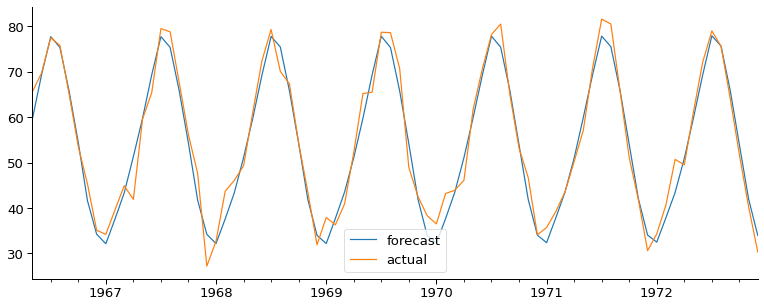

In [9]:
print("MAPE: {:.4f}".format(mape(cv1.actual, cv1.forecast)))
cv1.plot()
plt.show()

In [110]:
# def mape(df_cv):
#     """
#     MAPE: mean absolute percentage error
#     """
#     # return abs(df_cv.actual - df_cv.forecast).sum() / df_cv.actual.sum()
#     return abs((df_cv.actual - df_cv.forecast)/df_cv.actual).sum() / len(df_cv)

In [ ]:
# series= monthly_temp.temp
# horizon= 12
# start= 700
# step_size= 1
# order= (1,0,0)
# seasonal_order= (0,1,1,12)

series = monthly_temp.temp
horizon = 12
start = 700
step_size = 1
order = (1,1,0)
seasonal_order = (0,1,1,12)


cv2= cross_validate(series= series, horizon= horizon, start= 700, step_size= step_size, 
                    order= order, seasonal_order= seasonal_order)

MAPE: 0.0664


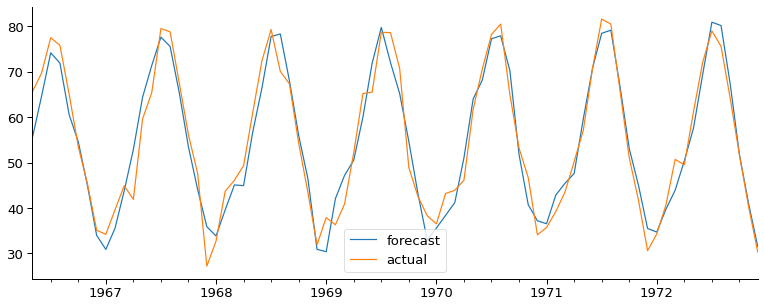

In [11]:
print("MAPE: {:.4f}".format(mape(cv2.actual, cv2.forecast)))
cv2.plot()
plt.show()

In [12]:
def mape(df_cv):
    """
    MAPE: mean absolute percentage error
    """
    # return abs(df_cv.actual - df_cv.forecast).sum() / df_cv.actual.sum()
    return abs((df_cv.actual - df_cv.forecast)/df_cv.actual).sum() / len(df_cv)

def cross_validate(series, horizon, start, step_size, order= (0,0,0), seasonal_order= (0,0,0,0), trend= None):
    '''
    Function to determine in and out of samples for testing of ARIMA model
    ------
    arguments:
        series (series): time series input
        horizon (int): how far in advance forecast is needed
        start (int): starting location in series
        step_size (int): how often to recalculate forecast
        order (tuple): (p,d,q) order of the model
        seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    Return
    ------
    Dataframe: gives forecast and actuals with date of prediction
    '''
    fcst= []
    actual= []
    date= []
    for i in range(start, len(series)- horizon, step_size):
        # print(i)
        # print(series[i])
        # print(series[:i+1])
        model= SARIMAX(series[:i+1], order= order, seasonal_order= seasonal_order, trend= trend).fit()
        fcst.append(model.forecast(steps= horizon)[-1])
        actual.append(series[i+horizon])
        date.append(series.index[i+horizon])
    return pd.DataFrame({'forecast': fcst, 'actual': actual}, index= date)

def grid_search_ARIMA(series, horizon, start, step_size, orders= [(1,0,0)], seasonal_orders= [(0,0,0,0)], trends= [None]):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                cv = cross_validate(series,
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mape(cv)<best_mape:
                    best_mape = mape(cv)
                    best_order = order_
                    best_seasonal_order = seasonal_order_
                    best_trend = trend_
    return (best_order,best_seasonal_order, best_trend, np.round(best_mape, 6))

In [ ]:
series = monthly_temp.temp
horizon = 12
start = 760
step_size = 3
orders = [(1,1,0),(1,0,0)]
seasonal_orders = [(0,1,1,12)]
trends = [None,'c']

GridCV= grid_search_ARIMA(series = series,
                  horizon = horizon,
                  start = start,
                  step_size = step_size,
                  orders = orders,
                  seasonal_orders = seasonal_orders,
                  trends=trends)

In [14]:
GridCV

((1, 0, 0), (0, 1, 1, 12), None, 0.035878)

In [15]:
import session_info
session_info.show()